### General advice (delete this cell before submitting for review)
> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Headers must appear in heirachical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.

> * The DEA Image placed in the title cell will display as long as the notebook is contained in one of the standard directories.
It does not work in the highest level directory (hence why it doesn't display in the original template notebook).
> * In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case (unless the tag is an acronym), separate words with spaces (unless it is the name of an imported module), and [re-use existing tags](https://github.com/GeoscienceAustralia/dea-notebooks/wiki/List-of-tags).
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


Before pushing this:
    * delete general advice cell 
    * go thru general advice cell
    * check packages
    * move scripts directory
    * move this notebook to frequently used code
    

# Polygonising pixel edges <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
The ability to get the pixel boundaries as a shapefile or other vector file type is very useful for remote sensing applications where the boundaries of the pixel are needed. This is useful for cases such as matching drone imagery with remotely sensed imagery. 


## Description
This notebook uses Digital Earth Australia to retrieve Landsat satellite data. 

1. First we load some landsat data for a chosen time frame using the dea-notebooks `load_ard` function
2. Then we convert our raster data into a polygon per pixel
3. Then we export our pixel edges polygons as a vector file (shapefile)

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [22]:
%matplotlib notebook
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio.features
from shapely.geometry import shape
import sys
import xarray as xr

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../../Scripts'))
from dea_datahandling import load_ard

sys.path.append('../Scripts')
from dea_plotting import rgb

#chessboard notebook
%matplotlib inline
from datacube.helpers import write_geotiff
from datacube.utils import masking
from datacube import Datacube
from datetime import datetime

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [23]:
dc = Datacube(app='Polygonise pixel edges')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


## Analysis parameters


* `vector_file` : A path to a vector file (ESRI Shapefile or GeoJSON)
* `attribute_col` : A column in the vector file used to label the output `xarray` datasets containing satellite images. Each row of this column should have a unique identifier
* `products` : A list of product names to load from the datacube e.g. `['ga_ls7e_ard_3', 'ga_ls8c_ard_3']`
* `measurements` : A list of band names to load from the satellite product e.g. `['nbart_red', 'nbart_green']`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Landsat, this is `(-30, 30)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection
* `align` : How to align the x, y coordinates respect to each pixel e.g. Landsat Collection 3 should be centre aligned `(15, 15)` 
* `

## Set up a query for our area of interest
Grab landsat satellite data first

In [24]:
products = ['ga_ls5t_ard_3', 'ga_ls7e_ard_3','ga_ls8c_ard_3'] #include all landsat here, as this is a demo notebook but we want to make it reusable for any time period ideally
measurements =['nbart_blue', 'nbart_green','nbart_red', 'nbart_nir','nbart_swir_1','nbart_swir_2']
resolution = (-30, 30)
output_crs = 'EPSG:3577'
align = (15, 15)

In [25]:
# Create a landsat query
ls_query = {
    'x': (153.40, 153.50),
    'y': (-27.40, -27.50),
    'time': ('2018-08-01', '2018-08-20'),
    'measurements': ['nbart_green','nbart_red', 'nbart_blue'], #only get the bands we need for plotting and segmenting
    'output_crs': output_crs,
    'align': align,
    'resolution': resolution,
    'group_by': 'solar_day'
}

Load available data from Landsat satellites

In [26]:
# Load landsat data using load_ard
ds = load_ard(dc=dc, 
              products=products,
              #min_gooddata=0.99,  # only take uncloudy scenes
              ls7_slc_off = False,                 
              **ls_query)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 1 time steps


### Plot up some data to take a look at it

Use the `rgb` function from `dea-plotting` module to look at our area of interest in true colour

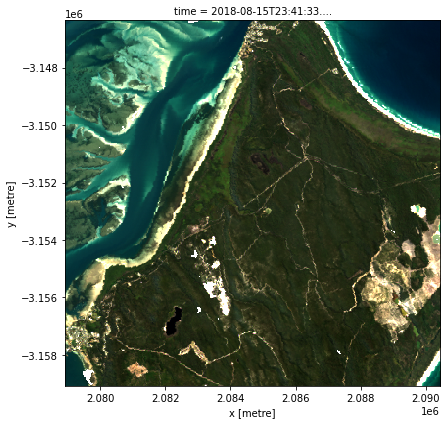

In [27]:
rgb(ds, bands = ['nbart_red','nbart_green','nbart_blue'], col='time')

choose an image index to plot:

In [28]:
image_index = 0

## Segment our image into per-pixel-polygons
Use the red band to create a polygon for each pixel. 

In [29]:
# Input array to segment and vectorise
input_array = ds.nbart_red[image_index]
input_transform = ds.affine
input_crs = ds.crs

# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

# Vectorise each unique feature in array
vectors = rasterio.features.shapes(source=unique_pixels.astype(np.int16), 
                                     transform=input_transform)

# Extract polygons and values from generator
vectors = list(vectors)
values = [value for polygon, value in vectors]
polygons = [shape(polygon) for polygon, value in vectors]

# Create a geopandas dataframe populated with the polygon shapes
poly_gdf = gpd.GeoDataFrame(data={'id': values},
                       geometry=polygons,
                       crs=input_crs)

In [30]:
poly_gdf

,id,geometry
0,0.0,"POLYGON ((2078925.000 -3146355.000, 2078925.00..."
1,1.0,"POLYGON ((2078955.000 -3146355.000, 2078955.00..."
2,2.0,"POLYGON ((2078985.000 -3146355.000, 2078985.00..."
3,3.0,"POLYGON ((2079015.000 -3146355.000, 2079015.00..."
4,4.0,"POLYGON ((2079045.000 -3146355.000, 2079045.00..."
...,...,...
162811,31739.0,"POLYGON ((2090295.000 -3159045.000, 2090295.00..."
162812,31740.0,"POLYGON ((2090325.000 -3159045.000, 2090325.00..."
162813,31741.0,"POLYGON ((2090355.000 -3159045.000, 2090355.00..."
162814,31742.0,"POLYGON ((2090385.000 -3159045.000, 2090385.00..."


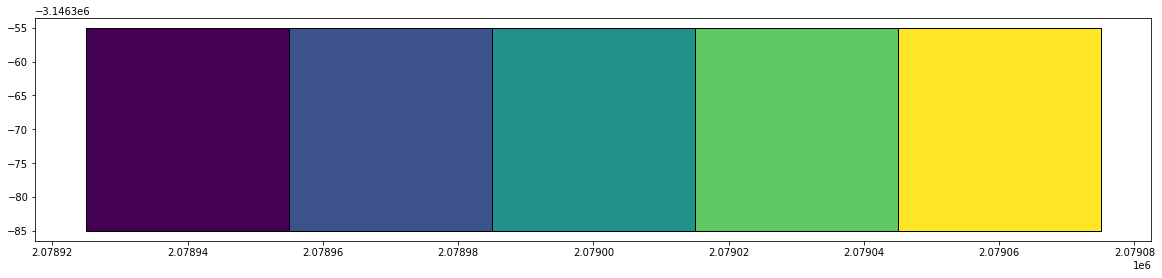

In [31]:
poly_gdf.head().plot(column='id', edgecolor='black', figsize=(20,20))
plt.show()

In [32]:
#get image date and location for file name

In [33]:
def create_filename(ds,image_index):
    image_date = str(ds.nbart_red[image_index].time.data)[:10]
    print(image_date)

In [34]:
create_filename(ds, imag)

NameError: name 'imag' is not defined

In [14]:
#write our new segmented shapefile out to a file
poly_gdf.to_file('TEST.shp')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [31]:
print(datacube.__version__)

NameError: name 'datacube' is not defined

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)